In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()

await node.lock()

Node 5fd22109-7e01-4065-9ca2-9a71dffe7c8e

In [2]:
import Local_NAV as local
from Global_NAV import *
import MotionCTR2 as mctrl
import Kal_FILTER as kfil
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import IPython
from IPython.display import display, clear_output
import time

from matplotlib import colors
from cvision_2 import *

%matplotlib inline

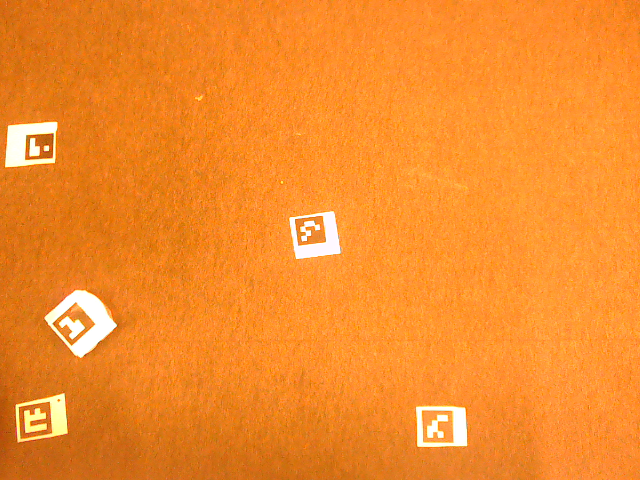

Goal position [[622.85677847 468.38030863]]


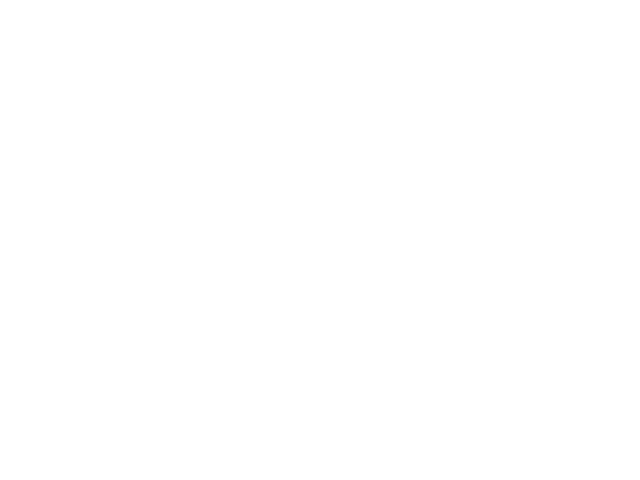

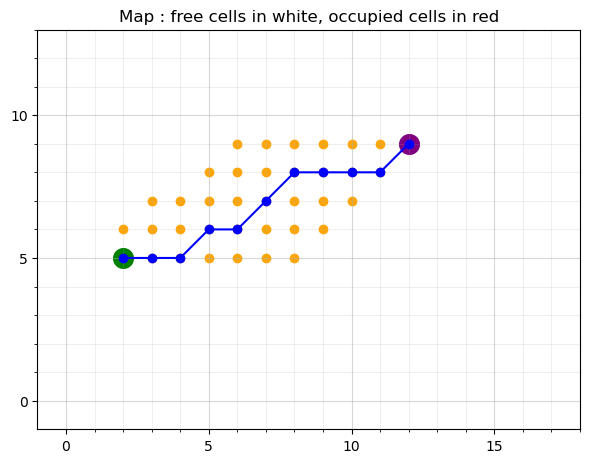

Position final goal [100, 250]
orient_goal 0.7883614731938429
delta_angle 0.016826216465402943
Control vector [0.88745474 0.86982852]
Robot position and angle (rad) [ 83.72474356 233.62799934   0.76236808]
State_estimate_k [ 84.18724492 234.07785201   0.76236827]
temporary goal:  [100, 250]
Position final goal [100, 250]
orient_goal 0.7888452347621764
delta_angle 0.02647696464583771
Control vector [0.88745474 0.86982852]
Robot position and angle (rad) [ 92.77606719 241.04724252   0.76085773]
State_estimate_k [ 92.69391685 241.04782329   0.7608578 ]
temporary goal:  [100, 250]
position 1 of 10 in path: 
Position final goal [150, 250]
orient_goal 0.15496439736629775
delta_angle -0.6058934038200797
Control vector [0.6064274  1.14994279]
Robot position and angle (rad) [104.04831745 253.34250369   0.76236808]
State_estimate_k [103.78928117 253.00071126   0.76236674]
temporary goal:  [150, 250]
Position final goal [150, 250]
orient_goal -0.06484435587305093
delta_angle -0.8272110916134876
Co

KeyboardInterrupt: 

In [3]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 95 #mm
R = 23 #mm
Ts = 0.5 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 20
threshold_for_convergence_local = 100
speed0 = 60
speedGain = 30

path = []
while True:
    if state == 0:
        # Create an adjusted dictionary of 5 markers of 4x4 bits.
        aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
        # Assign a marker to each objects to be recognized on the map
        # Generate three reference markers
        detector = create_detector(aruco_dictionary)
       

        for i in range(5):
            marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
            cv2.imwrite('marker' + str(i) +'.jpg', marker)
        # Definition of the references used to map the space
        ref1 = Obj(0, np.array([[0,0]]))
        ref2 = Obj(1, np.array([[0,0]]))
        ref3 = Obj(2, np.array([[0,0]]))

       
        # Definition of the objects to recognize in the space
        goal = Obj(3, np.array([[]]))
        thymio = Obj(4, np.array([[]]))

        map = Map(ref1,ref2,ref3,920,660)

        objects = np.array([ref1,ref2, ref3, goal, thymio])

        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                clear_output(wait=True)
                show_frame(frame)

                detect_objects(frame, detector, objects)
                if map.references_detected():
                    print('Goal position', map.localize(goal))
                    matrix = map.matrix(frame, thymio, goal)

                    if check_matrix(matrix):
                        path, visitedNodes = global_path(matrix)
                        print_path(matrix, path, visitedNodes)
                        path = np.multiply(path, 50)
                        N = np.size(path,1)
                        path_found = True
                        state_estimate_k = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])

        # Navigation
        state = 1    
        # Global navigation state
    if state == 1:
    
        while not_arrived == True:

            #Check if there is obstacles
            prox_horizontal = local.read_prox_sensors(node,client)
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            state = local.update_state(state,obst,client)
            if state == 2:
                break

            # Path following: control law
            print("Position final goal", [path[0,k],path[1,k]])
            vr, vl = mctrl.control_law(state_estimate_k, path[0,k], path[1,k],speed0,speedGain)
            #control_vector_k_minus_1 = mctrl.convert_velocity2vw(vr,vl,C_conv_toThymio_right, C_conv_toThymio_left,L,R) if we use [v,w] as control variables in state space model
            control_vector_k_minus_1 = np.array([vr/C_conv_toThymio_right,vl/C_conv_toThymio_left]) #if we use [vr,vl] as control variables in state space model
            print("Control vector", control_vector_k_minus_1)
            mctrl.set_motors(vl,vr,node)
            
            
            # Take Thymio position if camera is not obstructed and update state estimate with kalman filter
            if video.isOpened:
                ret, frame = video.read()
                new_frame = frame.copy()
                if ret == True:
                    
                    #clear_output(wait=True)
                    detect_objects(frame, detector, objects)
                    
                    ref1.draw(new_frame, [255,0,0])
                    ref2.draw(new_frame, [0,255,0])
                    ref3.draw(new_frame, [0,0,255])
                    goal.draw(new_frame, [255,255,255])
                    thymio.draw(new_frame, [255,0,0])
                    #show_frame(new_frame)
                    
                    
                    if map.references_detected(): #camera correctly working
                        camera_obstructed = 0

                        if np.size(map.localize(thymio), 0) > 0: #camera working correctly
                            #take robot position from camera
                            z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])  
                            print("Robot position and angle (rad)", z_k_observation_vector)  
                            # update state estimate with kalman filter
                            #state_estimate_k = z_k_observation_vector #if you don't use kalman filter
                            state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed)
                            print("State_estimate_k", state_estimate_k)
                            print("temporary goal: ", [path[0,k], path[1,k]])   
                    else: #camera obstructed
                        camera_obstructed = 1
                        print("WARNING:NOCAMERA--WARNING:NOCAMERA--WARNIN:NOCAMERA--WARNING:NOCAMERA")
                        #Measurements are not updated by camera but only by kalman filter
                        state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed) 
                        print("State_estimate_k", state_estimate_k)
                        print("temporary goal: ", [path[0,k], path[1,k]])

            # Check if the robot has arrived to the temporary goal
            if np.linalg.norm(state_estimate_k[:2] - np.array([path[0,k], path[1,k]])) < threshold_for_convergence:
                if k >= N-1:
                    not_arrived = False
                    print('The robot has arrived to the final goal')
                    mctrl.stop_motors(node)
                    #break

                elif k + N//8 < N-1:
                    k = k + N//8 # go to the next temporary goal 
                else:
                    k = N-1   # go to the final goal
                print("position {} of {} in path: ".format(k,N-1))
                

 
            time.sleep(Ts)   


    # Local navigation state
    if state == 2:         
        #We get the sensor value
        prox_horizontal = local.read_prox_sensors(node,client)
        
        #We fill the obst list with the sensor value
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        
        #We calculate the motor speed to avoid the object -> potential field method
        motors_speed = local.local_navigation(obst)
        
        #We set the motor speed
        mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
        #We update the state
        state = local.update_state(state,obst,client)
        if state == 1:
            vr = speed0
            vl = speed0
            mctrl.set_motors(vl,vr,node)
            if k + 40 < N-1:
                k = k+40
            else: 
                k = N-10
            print("koala")
             
            

       


In [ ]:
motors_speed = local.global_path()
local.set_motors(motors_speed[0],motors_speed[1],node) 
local.stop_motors(node) 


AttributeError: module 'Local_NAV' has no attribute 'global_path'

In [ ]:
mctrl.stop_motors(node)